<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_chapter6_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 相関・回帰分析

*相関関係は因果関係を含意しない (Correlation does not imply causation)*

[この章の目的]
初歩的な相関分析と回帰分析がPythonで出来るようになる。


補足資料: [講義ノート](https://drive.google.com/file/d/1ZKi8DJFSg00xir1IoEQiw3z9vxmejeCv/view)





今回使用するライブラリをインポートしておきましょう。

In [5]:
from matplotlib import pyplot as plt 
!pip install japanize-matplotlib 
import japanize_matplotlib 
import numpy as np 

     |████████████████████████████████| 4.1 MB 5.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=cb3aa67e03f06b9d0bba74e68c1143958c7b4e26ebd5bf022872a738ebc13daf
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


## 相関分析 (復習)

1年生前期の必修科目[DS入門]でも(多くの学科で)[相関分析]を学習しました。  

解析したいデータが２種類だけなら、プログラムを使うありがたみはそれほど感じられないと思いますが  
「多くのデータ間の相関関係を系統的に調べたい」  
あるいは「複数年度に渡るデータを解析したい」となると、  
Excelはデータが大きくなるとすぐに挙動が重くなってしまうため  
精神によくありません(私見)ので、Pythonで扱うのがオススメです。

以下では、復習を兼ねて簡単な例の相関分析を扱って、  
時間に余裕があれば前章のおまけの詳細を扱うことにします。

まずは簡単な例から初めましょう。


In [3]:
x= [3.1, 4.3, 6.6, 13.2, 19.1, 20.9, 26.4, 25.1, 21.9, 15.7, 9.6, 3.8]
y= [568, 572, 804, 833, 930, 965, 1213, 1120, 835, 540, 451, 502]

上に示したのは、2017年の宇都宮市における月別の平均気温$x$と  
世帯ごとのアイスクリーム・シャーベットの平均消費金額$y$です。  
散布図にすると↓こんな感じ

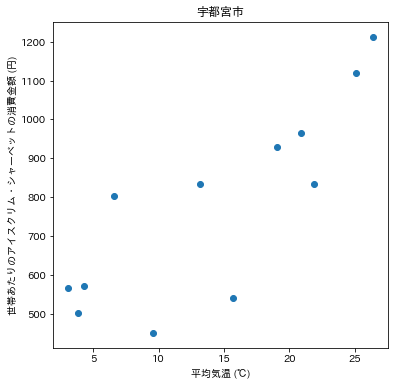

In [6]:
plt.figure(figsize=(6,6)) 
plt.title("宇都宮市") 
plt.xlabel("平均気温 (℃)")
plt.ylabel("世帯あたりのアイスクリム・シャーベットの消費金額 (円)")
plt.scatter(x,y)
plt.show()
plt.close()

「平均気温とアイスの消費には相関がありそう」という直感の通り、  
正の相関があることが見て取れます。

では"どれほどの"相関を持つかを表す量として相関係数を算出してみましょう。  
相関係数$r$は以下のように定義されます。
$r= \frac{ \sum^n_i (x_i-\bar{x})(y_i-\bar{y})}{ \sqrt{\sum^n_i (x_i-\bar{x})^2 \sum^n_i (y_i-\bar{y})^2} }$  
$\bar{x},\bar{y}$はそれぞれ$x,y$の平均値で、数式で書くと$\bar{x} \equiv \frac{1}{n} \sum^n_i x_i $,　$\bar{y} \equiv \frac{1}{n} \sum^n_i y_i $  
という感じです。  
ここで$\equiv$は[定義]を表し、下付き添字$i$は$x$の$i$番目の要素であることを表します。  
(つまり$x$をn次元ベクトルとみなしたときの$i$成分が$x_i$とも言えますね)  
今考えているデータの場合、$\sum$の和記号は$i$は1から12までの値を取り  
対応する値を足し上げることを意味します。  
("$i$の和が1から12までを走る"といったりもする)

この$r$の定義では、$r$は必ず-1から1までの値を取り※  
1.0(-1.0)に近づくにつれて強い正(負)の相関を持ちます。  
(強いというのは曖昧な表現で絶対的な線引がある訳ではありません)
>$|r|\leq1$は、コーシーシュワルツの不等式を用いるか  
上の$r$の定義と$n$次元ベクトル同士の内積の定義とを見比べると示すことが出来ます(暇があればやってみましょう)。  

では```x``` ,``` y```２つのリストを引数に持ち、この相関係数$r$を返す関数を作成してみましょう。

にらめっこするために式を再掲しておきます:
$r= \frac{ \sum^n_i (x_i-\bar{x})(y_i-\bar{y})}{ \sqrt{\sum^n_i (x_i-\bar{x})^2 \sum^n_i (y_i-\bar{y})^2} }$  

In [9]:
### ライブラリを一切使わない方法
# ※1 xとyの長さが違う場合はエラーとし、返り値Noneを返す。欠損値がないことを仮定しているとも言える.
# ※2 Pythonではwarning(警告)を返す機能などもありますが、授業では扱わないのでNoneとした。

def cor_coeff(x,y):
    if len(x) != len(y):
        print("x and y must be the same size!!") # ※1
        return None # ※2
    n = len(x) 
    ## 平均を計算
    xbar = sum(x)/n; ybar = sum(y)/n 

    ##分子(numerator)の和を計算 (初期値を0に)
    s_n = 0.0 
    for i in range(n):
        s_n += (x[i]-xbar)*(y[i]-ybar)

    ##分母(denominator)の計算 (和を先に計算して積を取り、最後にsquare rootをとる)
    s_x = 0.0; s_y = 0.0
    for i in range(n):
        s_x += (x[i]-xbar)**2 
        s_y += (y[i]-ybar)**2
    s_d = (s_x * s_y)**0.5
    # 一行で書くなら
    #s_d = ( sum([(x[i]-xbar)**2 for i in range(n)]) * sum([(y[i]-ybar)**2 for i in range(n)]) )**0.5

    return s_n/s_d # 分子/分母の値を返す

cor_coeff(x,y)

0.8262304630498378

という風に、$r$が約0.83で、非常に強い正の相関を示すことがわかりました.

numpyライブラリを使うともう少しシンプルに書けるので、それもやっておきましょう.

In [10]:
def cor_coeff_np(x,y):
    xbar = np.mean(x); ybar=np.mean(y) #np.mean()は整数・実数値が入ったリスト(やnumpy array)の平均を計算
    return np.dot(x - xbar,y-ybar) / np.sqrt( np.dot(x-xbar,x-xbar) * np.dot(y-ybar,y-ybar) ) 

cor_coeff_np(x,y) 

0.8262304630498377

とすると、関数自体は数行で書けてしまいました。  
さらに$\bar{x},\bar{y}$をいちいち定義しないように書き換えれば、関数の中身自体は一行でかけてしまいます。

上のコードを少し補足しておくと...分子や分母に現れる  
$\sum^n_i (x_i-\bar{x})(y_i-\bar{y})$や$\sum^n_i (x_i-\bar{x})^2 $といった項は、  
$i$番目の成分に$x_i-\bar{x}$を持つベクトル$\tilde{x}$と  
$i$番目の成分に$y_i-\bar{y}$を持つベクトル$\tilde{y}$を定義しておくと、  
$\tilde{x}\cdot\tilde{y}$,　$\tilde{x}\cdot\tilde{x}$,　$\tilde{y}\cdot\tilde{y}$といったように、  
ベクトルの内積の形でいずれも表すことができます。

numpyにはブロードキャスト機能(Numpyのノートを参照)や  
ベクトル積を計算する関数```dot```が備わっているので、  
それらを活用することで短く実装することができました。

実はnumpyには相関係数を計算する関数```corrcoef()```が予め用意されていて


In [ ]:
print(np.corrcoef(x,y))
print("r(x,y)=", np.corrcoef(x,y)[0,1])

を使えば  
[ xとxの相関(=1.0), xとyの相関;  
yとxの相関, yとyの相関(=1.0)]  
といった2行2列の相関行列を取得することが出来ます。  
確かに上の相関行列の[0,1]成分は、  
さっき計算した$r$の値と一致しています。

「初めからそれを教えろ！」と思うかもしれませんが、  
考えたい量を数式として定義してそれをプログラムに変換し、  
値が正しいかどうかを確かめておくのは、式とプログラミング、  
双方の理解を深める上で非常に重要なプロセスです。  

### 相関分析と因果関係

前章のファイル操作では、エクセルファイルからデータを読み込んで  
系統的に相関分析を行うコードを紹介しました。


以下では、そのうちの一つのグラフを見ながら、  
冒頭の*相関関係は因果関係を含意しない (Correlation does not imply causation)*  
に関して説明します。

下の図は、2017年の家計調査・気候データから作成した散布図で、  
千葉市での平均気温と、しめじの消費支出の間の相関を示しています。

<img src="https://drive.google.com/uc?export=view&id=17DH8RCaU_9DC-fjt_k_On6duL8ixtd31" width = 50%>


生産量と平均気温の間に、強い負の相関が見て取れますが、これはどうしてでしょうか？  
「寒い季節には鍋が食べたくなるから」と言われるとふむふむと感じる一方で  
「そもそも生産量が冬に多く、市場に出回る量が多いから」と考えることもできます。  
したがって、このデータを見ただけでは、しめじが冬によく売れる理由までははっきりとは分かりません。

事実、しめじの旬はGoogle検索によると9月下旬から11月初旬とのことで、  
最も売れている時期(12月1月)とは少し時期にズレがあり、  
購買意欲は必ずしも"旬"によって決まっている訳ではなさそうな印象を受けます。

気温と特定の野菜の購買意欲の真の関係を知りたければ、  
「その野菜はビニールハウスなどの生産設備の向上で年中、安定した味で生産ができる」  
「比較的新しい品種で〇〇といえば秋、のような固定観念がない」  
「季節ごとの生産量がほぼ同じ」  
など、他の条件が揃った状況下で比較しなければ確度の高い議論は難しいでしょう。

このように、因果関係を紐解くことは、我々が思うほど容易ではなく、  
それ自体が一つの学問体系になっています。  
気になる方は、たとえば[因果推論]で調べてみましょう。


「我々が見ている相関関係は２次元よりも遥かに高次元の空間での関係  
を低次元へ射影した影を見ているに過ぎない」とも言えるでしょう。

疑似相関に関するその他の話題は以下を参照してください  
* [講義ノート](https://drive.google.com/file/d/1ZKi8DJFSg00xir1IoEQiw3z9vxmejeCv/view)の3.2章  
* [疑似相関をまとめたおもしろいサイトはこちら](https://www.tylervigen.com/spurious-correlations)  




## 回帰分析

以下では自分が立てたモデルを表現する関数のことを*モデル関数*、  
モデル関数とデータとの齟齬を最小化するようにモデル関数の係数を決定することを**回帰**、  
そして回帰に基づく分析を指して**回帰分析**と呼ぶことにします。

データとモデル間の齟齬を表現する方法はいくつかありますが、  
以下では最もポピュラーな誤差の二乗和を採用することとし、  
その最小化を考えていきましょう(最小二乗法とも呼びます)。

$D$個の点$\{x_1,x_2,...,x_D\}$でのyの値$\{y_1,y_2,...,y_D\}$が観測されているとき、  
最小二乗法とは、ある決められたモデル関数$f(x)$との齟齬$\chi^2 = \sum^D_{i=1} (y_i - f(x_i))^2$を  
最小化するように関数$f$の係数を調整することとも言いかえられます。

$f$自体をどう決める/設計するかも重要な話題ですが、授業では深入りしません。  
たとえば回帰を行う関数として、ニューラルネットワークを採用する立場を採ることも可能です。  
参照: [おまけのノートブック: ニューラルネットワークによる回帰](https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_chapter_ArtificialNeuralNetwork.ipynb)

以下では、$f(x)$として単純な多項式のみを考えることにします。  
まず回帰を学ぶために、適当なデータを生成しておきましょう

In [ ]:
def create_toy_data(sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = np.sin(2*np.pi*x) + np.random.normal(scale=std, size=x.shape)                                                                                                                 
    return x, t
    
np.random.seed(1234)
x,y = create_toy_data(10,1.e-1)

これをグラフにしてみると...

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="Data")
ax.legend()
plt.show()
plt.close()

こんな感じ。

このデータを、$p$次元の多項式(p=0,1,2,...)でフィッティングすることを考えてみましょう。  
$p$次式($p$次元多項式)は、$p+1$個の係数, $a_0$から$a_p$を使って
$a_0 + a_1x + a_2x^2\cdots +a_p x^p $と書くことが出来ます。


$p$次元のフィッティングは、実はnumpyにある関数```polyfit()```を利用すれば一瞬で行えます。  

(全学部向けの授業なのでとりあえずライブラリを利用することにします。  
他にもscikit-learnなどのライブラリもより高度な関数のフィッティングが可能です。  
第2回のレポートでは、ごく簡単な場合にもう少し自分の手で愚直にフィッティングをすることを考えてもらう予定です。)


> 進んだ注:  
多項式で回帰を行う場合には、実はパラメータの最適解は"閉じた形"で与えられます。  
この辺りのことは、おまけのノートブック[ベイズ線形回帰](https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_chapter_Bayesian_linear_regression.ipynb)で詳しく書いています。  
なお"閉じた形"というのは、数学や物理をやっていると出てくる表現で、  
答えが具体的な形で書き下せる、程度の意味です。  
たとえば 行列$A$、ベクトル$\vec{x},\vec{y}$,スカラー$\lambda$について方程式$A\vec{x}=\lambda \vec{y}$が成り立つとき、$A$の逆行列をどうやって求めるか(数値的にやるのか解析的に求めるのか)はさておき、$\vec{x} = \lambda A^{-1}\vec{y}$と書き直せるので「$\vec{x}$は閉じた形で与えられる」といった程度の意味です。



たとえば今のデータを３次式でフィットしたければ、以下のようにします

In [ ]:
xp = np.linspace(0, 1, 500) ## 多項式をplotするためのxの値を準備(グラフをなめらかにするために、0から1までの間の500点を等間隔に取る)
p=3 #多項式の次元を決める. 今は3次式.
yp = np.poly1d(np.polyfit(x, y, p))(xp)

```np.polyfit(x, y, p)```では、データのx,yの値と多項式の次元pを引数として与え、  
$p$次の多項式でデータ$(x,y)$をfitしなさい  
(つまり、$p$次までの係数を関数がデータと整合するように"最適化"しなさい)  
という指令を与えています.

```np.poly1d( np.polyfit(x, y, p) )(xp)```では、  
fitしたp次元の係数をもつ多項式に```xp```(今は500点)を代入して、対応する```y```の値を返します。  
上のコードはこの返り値をypという変数に格納しています。

最後に、調整(最適化)された3次式の係数を表示してみました。  
このように、$p$次式の係数を考えるときは0-based indexing(ゼロはじまりのインデックス)が直感と合っていて便利ですね。

グラフを描いてみるとこんな感じ。

In [ ]:
#お絵かき
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="Data")
ax.plot(xp, yp,label="p=3")
ax.legend()
plt.show()
plt.close()

最適化された係数を表示してみるとこんな感じ。

In [ ]:
print("最適化された3次式の係数", np.polyfit(x,y,p)) 

ちなみに、表示される係数は次数が高いところから$a_3,a_2,a_1,a_0$です(ややこしい...)。


さて、$p$次の多項式は$p-1$次の多項式を特別な場合として含むため、  
一般に$p$(多項式の次元)を増やせば、より複雑な関数を表現することができます。  
(2次式は3次式の$a_3=0$の場合ですよね？)

$p$を複数変えながら比較した図を作ってみましょう。  
方法は$p$に関するループを回すだけです。

In [ ]:
ps = [0,1,3,6,9]
ys = []
xp = np.linspace(0, 1, 500) ## 多項式をplotするためのxの値を準備
for p in ps:
    ys += [np.poly1d(np.polyfit(x, y, p))(xp)]

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(x, y, facecolor="none", edgecolor="b", s=80, label="Data")
for i in range(len(ps)):
    ax.plot(xp, ys[i],label="p="+str(ps[i]),alpha=0.8)
ax.legend(loc="upper right")
plt.show()
plt.close()

> 注: 今の場合、コードをよく見るとデータはsin関数に適当なノイズを足したものだということが分かります。  
解析の手法を学ぶ際には、このように答えを知っている状態からはじめて、手法がうまくデータを説明しているかどうかを検証したりします。一見ズルっぽいですが、重要なプロセスです。  

現実のデータ解析の状況では、背後にある"真の関数"が分かっていることは非常に稀ですし、  
「興味のあるデータが、人間がよく知っている単純な式(有限次元の多項式や指数関数)で  
完全に表現できる道理はない」ということも抑えておくべき重要な点です.  
真の関数というのは一般に[神のみぞ知る]で、  
人間ができることは出来るだけ尤もらしい関数を見つけ、  
その背後にあるメカニズム(の主要部分)を解明することです.  

一般に、関数をどんどん複雑なものにしていくにつれて、  
表現できるデータの幅は大きく拡がります。  
その一方で、用意した関数がデータに過度に適合するあまり、  
未知の点での値の予測精度が著しく損なわれている危険性があります。  
このことを予言能力がない(汎化性能がない/データに過適合している) と言ったりします。  
データの背後にあるメカニズムが何かを考えたり理論的な解析をして初めて、  
回帰に用いる関数の妥当性が検証できるという点に注意しましょう。


### (余談1) 100メートル走のタイム

上記のことに関連して、こういう例を考えてみましょう。

In [ ]:
y = [ 10.06, 10.03,10.02, 9.95,9.93, 9.92,9.9, 9.86,9.85, 9.84, 9.79, 9.78, 9.77, 9.74,9.72,9.69,9.58 ]
x = [1964, 1968,1968,1968,1983,1988,1991,1991,1994,1996,1999,2002,2005,2007,2008,2008,2009 ]

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.set_xlabel("year"); ax.set_ylabel("Mens 100m")
ax.scatter(x,y,marker="o",color="red")
plt.show()
plt.close()

図にしたのは、男子100mの世界記録の推移です。

このデータに対して「$p=3$の多項式でフィットして予測する」という立場をとってみましょう。

In [ ]:
xp = np.arange(2020,2101,1)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_xlabel("year"); ax.set_ylabel("Mens 100m")
ax.set_xlim(1960,2100)
ax.set_ylim(0,12)
for p in [3]:
    yp = np.poly1d(np.polyfit(x, y, p))(xp)
    ax.plot(xp,yp,marker="x",label="p="+str(p))
ax.scatter(x,y,marker="x",color="red")    
ax.legend(loc="upper right")
plt.show()
plt.close()

当然おかしな予測だと気がつくはずです。  
なぜなら、2080年代には100m走のタイムがゼロになってしまうからです。

今の場合、我々はこのデータが100走の世界記録のタイムの推移であること、つまり
* 非増加関数であること
* 必ず正の値であること

など、データが持つべき性質を予め知っているので、  
「このデータに対して単純な多項式回帰を当てはめるのはおかしい」  
と気がつくことが出来ます。  

**でも、他のデータではどうでしょうか？**

データを分析するためには、データの値だけをみて闇雲に分析するだけではダメで、  
データの背景やドメイン知識が不可欠である、という好例です。

### (余談2) 新型コロナウイルス感染症の陽性者数の推移に関して
回帰分析に関連して、この話題も取り上げておきましょう。  

我々が現実世界で観測することのできる種々の[値]というのは、  
何らかの関数$f(x)$の、ある$x$での(実現)値と言えるかと思います。  
テレビで見るコロナウイルスの感染者数の推移も日付に対する関数になっていたりします。

ただし一般に物事の背景にある"真の関数"というのは多次元の変数に対する複雑な関数になっているはずで、  
コロナウイルスの感染者数の推移も単なる時間に対する１変数の関数であるはずなどがありません。  

日付に対して陽性者数の推移をプロットして「このままだと指数関数的に増加する」  
という予想を立てることは簡単ですが、一般に物事は多様な要素が絡み合っています。  
たとえば検査数や我々の外出自粛や国・都道府県ごとの取り組み・政策,  
ウイルスの変異,その他様々な要素に左右されるはずです。

我々人間がグラフにして理解できるのはたかだか３次元(３つの変数がある状況)までです。  
言い換えれば、人間は物事を理解するときに本来D次元(D>>3, Dは３よりずっと大きい)  
の変数で定義される関数を、3次元以下に射影した「影」をみて理解しようとする生き物だということは、  
意識しておくべきでしょう。


一度目の感染ピークが訪れて緊急事態宣言が出され、  
報道が加熱していた頃には、「ぼく(わたし)が考えた最強のモデル」  
を使って感染者数を予測して危険を煽ったり、あるいは逆に  
「過度に心配する必要がない」などと主張したりする専門家・非専門家が数多くいました。  
また事態が収束したあとに「私のモデルはこんなに正しかった」という人も現れることでしょう。  
ですが、それは極めて高い蓋然性で偶然です。  
無限の数の関数を考えれば、データに適合するものが存在してもおかしくはありません。  
何にでも言えることですが、モデルを立てて終わり、ではなく検証する姿勢が重要です。

# LICENSE


Copyright (C) 2021 Sota Yoshida

[ライセンス:クリエイティブ・コモンズ 4.0 表示 (CC-BY 4.0)](https://creativecommons.org/licenses/by/4.0/deed.ja)